# Import of libraries and data, and preprocessing

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from files.preprocessing import *

In [2]:
data_raw=pd.read_csv("./data/Train.csv")
meta=pd.read_csv("./data/airqo_metadata.csv")

In [3]:
# TODO request "keep_location" argument
data = preprocessing(data_raw, use_location=False, only_means=False, keep_location=True)

/Users/mkinzler/neuefische/ML-Project-1/files/preprocessing.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(features,1,inplace=True)


# Plots

In [19]:
station_order = ['A', 'B', 'C', 'D', 'E'] 

## Target (PM2.5)

In [11]:
data.groupby('location')[['target']].describe()

target                                                         \
           count       mean        std        min        25%        50%   
location                                                                  
A         5122.0  57.654407  40.153730   1.452619  33.945973  46.801340   
B          767.0  49.864973  31.257994   5.364419  27.946675  43.527442   
C         1753.0  97.772233  71.094473  14.514348  44.751304  72.774667   
D         4990.0  58.155597  30.230180   6.163191  38.458511  50.526938   
E         2907.0  37.800361  22.487640   2.150000  23.144689  32.986667   

                                  
                 75%         max  
location                          
A          68.479103  447.340000  
B          62.150756  171.252564  
C         130.600417  475.820000  
D          69.716117  287.689412  
E          45.665000  218.505385

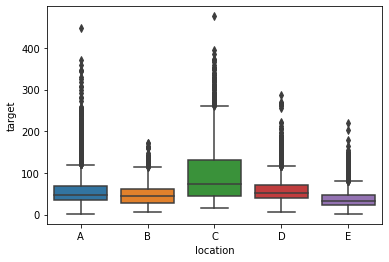

In [20]:
sns.boxplot(data=data, x='location', y='target', order=station_order);

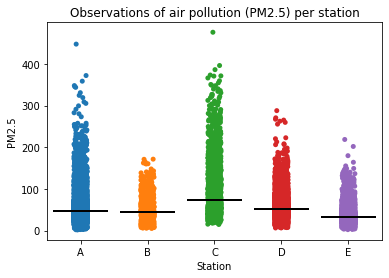

In [21]:
sns.stripplot(data=data, x='location', y='target', order=station_order, zorder=1)
sns.boxplot(data=data, x='location', y='target', order=station_order, zorder=2,
    medianprops={'color': 'k', 'ls': '-', 'lw': 2}, whiskerprops={'visible': False}, showfliers=False, showbox=False, showcaps=False
    ).set(title='Observations of air pollution (PM2.5) per station', xlabel='Station', ylabel = 'PM2.5')
plt.savefig('images/pm2_5_per_station.jpg');

## Metadata (influence of surrounding on pollution)

### Cooking with charcoal (and firewood), and burning of waste

In [13]:
meta[['location', 'dist_trunk', 'dist_primary', 'dist_secondary', 'dist_tertiary', 'dist_unclassified', 'dist_residential', 'popn', 'hh', 'hh_cook_charcoal', 'hh_cook_firewood', 'hh_burn_waste']]

,location,dist_trunk,dist_primary,dist_secondary,dist_tertiary,dist_unclassified,dist_residential,popn,hh,hh_cook_charcoal,hh_cook_firewood,hh_burn_waste
0,A,NaN,14.695789,343.595039,575.917422,330.609776,254.307415,4763,809,508,43,142
1,B,528.078476,2172.680462,1144.376412,531.103271,65.142004,1.042809,22243,5735,116,1144,239
2,C,32.885520,4794.704552,12.730489,72.459340,406.967815,13.931350,97895,26873,21316,751,9835
3,D,NaN,265.896472,NaN,339.693908,76.024389,11.601442,3596,663,7,651,99
4,E,850.423131,NaN,1738.872942,137.722087,449.591885,3.836589,6064,1297,985,26,43


In [16]:
# doesn't include hh_cook_firewood
# cook_burn = meta[['location', 'hh_cook_charcoal', 'hh_cook_firewood', 'hh_burn_waste']].set_index('location')
cook_burn = meta[['location', 'hh_cook_charcoal', 'hh_burn_waste']].set_index('location')

# cook_burn.columns = 'cooking w/ charcoal', 'cooking w/ firewood', 'burning waste'
cook_burn.columns = 'cooking w/ charcoal', 'burning waste'
cook_burn

,cooking w/ charcoal,burning waste
location,,
A,508,142
B,116,239
C,21316,9835
D,7,99
E,985,43


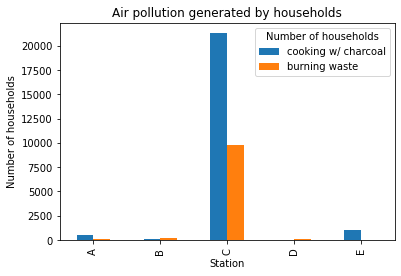

In [17]:
ax = cook_burn.plot(kind='bar')
ax.set(xlabel = 'Station', ylabel='Number of households', title='Air pollution generated by households')
ax.legend(title='Number of households')
ax.get_figure().savefig('images/n_hh_cooking_burning.jpg')

### Roads nearby

<AxesSubplot:xlabel='location'>

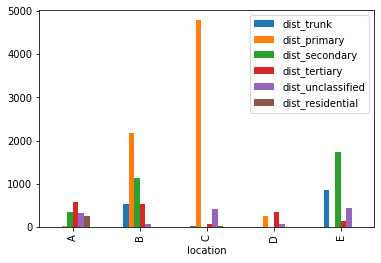

In [18]:
meta[['location', 'dist_trunk', 'dist_primary', 'dist_secondary', 'dist_tertiary', 'dist_unclassified', 'dist_residential']].set_index('location').plot.bar()

## Distribution of features

### Temperature

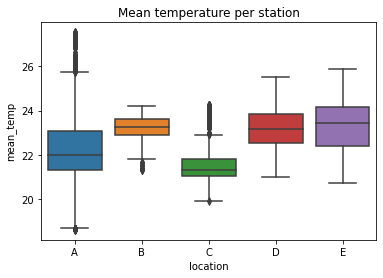

In [26]:
sns.boxplot(data=data, x='location', y='mean_temp', order=station_order).set(title='Mean temperature per station');

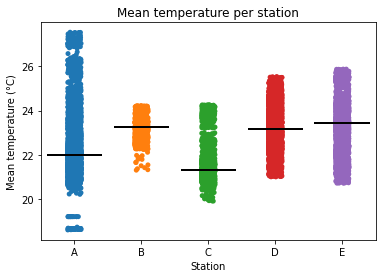

In [23]:
sns.stripplot(data=data, x='location', y='mean_temp', order=station_order, zorder=1)
sns.boxplot(data=data, x='location', y='mean_temp', order=station_order, zorder=2,
    medianprops={'color': 'k', 'ls': '-', 'lw': 2}, whiskerprops={'visible': False}, showfliers=False, showbox=False, showcaps=False
    ).set(title='Mean temperature per station', xlabel='Station', ylabel = 'Mean temperature (°C)')
plt.savefig('images/mean_temp_per_station.jpg');

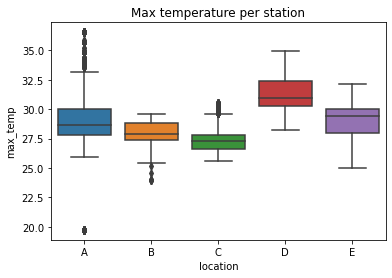

In [28]:
sns.boxplot(data=data, x='location', y='max_temp', order=station_order);

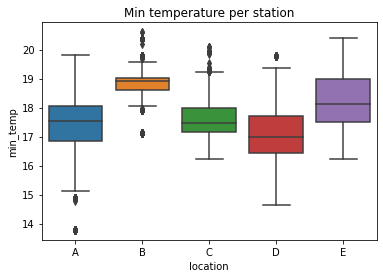

In [29]:
sns.boxplot(data=data, x='location', y='min_temp', order=station_order).set(title='Min temperature per station');

### Atmos. pressure

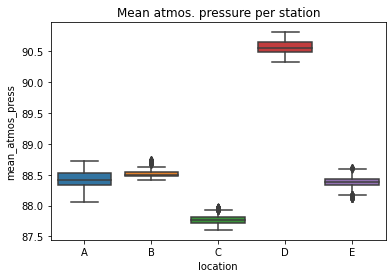

In [30]:
sns.boxplot(data=data, x='location', y='mean_atmos_press', order=station_order).set(title='Mean atmos. pressure per station');

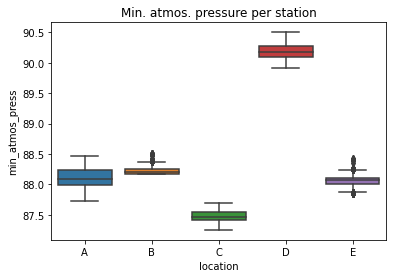

In [32]:
sns.boxplot(data=data, x='location', y='min_atmos_press', order=station_order).set(title='Min. atmos. pressure per station');

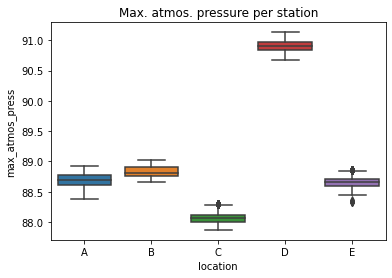

In [33]:
sns.boxplot(data=data, x='location', y='max_atmos_press', order=station_order).set(title='Max. atmos. pressure per station');

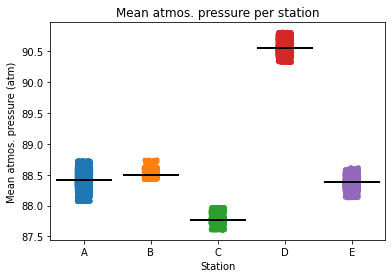

In [34]:
sns.stripplot(data=data, x='location', y='mean_atmos_press', order=station_order, zorder=1)
sns.boxplot(data=data, x='location', y='mean_atmos_press', order=station_order, zorder=2,
    medianprops={'color': 'k', 'ls': '-', 'lw': 2}, whiskerprops={'visible': False}, showfliers=False, showbox=False, showcaps=False
    ).set(title='Mean atmos. pressure per station', xlabel='Station', ylabel = 'Mean atmos. pressure (atm)')
plt.savefig('images/mean_atmos_press_per_station.jpg');

### Wind speed

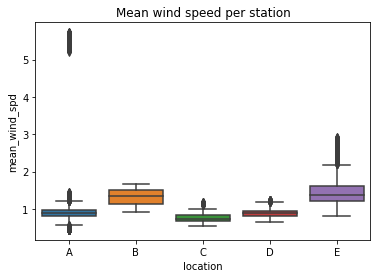

In [35]:
sns.boxplot(data=data, x='location', y='mean_wind_spd', order=station_order).set(title='Mean wind speed per station');

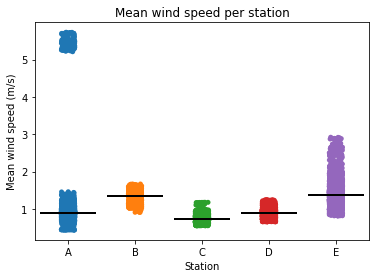

In [36]:
sns.stripplot(data=data, x='location', y='mean_wind_spd', order=station_order, zorder=1)
sns.boxplot(data=data, x='location', y='mean_wind_spd', order=station_order, zorder=2,
    medianprops={'color': 'k', 'ls': '-', 'lw': 2}, whiskerprops={'visible': False}, showfliers=False, showbox=False, showcaps=False
    ).set(title='Mean wind speed per station', xlabel='Station', ylabel = 'Mean wind speed (m/s)')
plt.savefig('images/mean_wind_spd_per_station.jpg');

### Precipitation

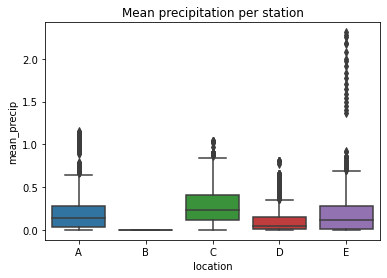

In [37]:
sns.boxplot(data=data, x='location', y='mean_precip', order=station_order).set(title='Mean precipitation per station');

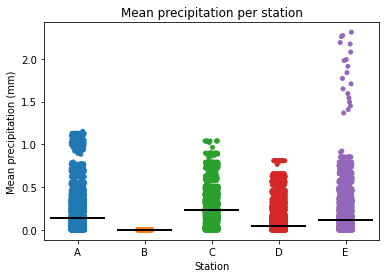

In [38]:
sns.stripplot(data=data, x='location', y='mean_precip', order=station_order, zorder=1)
sns.boxplot(data=data, x='location', y='mean_precip', order=station_order, zorder=2,
    medianprops={'color': 'k', 'ls': '-', 'lw': 2}, whiskerprops={'visible': False}, showfliers=False, showbox=False, showcaps=False
    ).set(title='Mean precipitation per station', xlabel='Station', ylabel = 'Mean precipitation (mm)')
plt.savefig('images/mean_precip_per_station.jpg');

## Data quality

In [42]:
nans_per_obs = data_less_raw.copy()

features = ['temp', 'wind_dir', 'wind_spd', 'rel_humidity', 'atmos_press', 'precip']

for feature in features : 
    nans_per_obs[feature]=nans_per_obs[feature].apply(lambda x: np.count_nonzero(np.isnan(x)))

KeyError: 'temp'

In [ ]:
nans_per_obs

In [ ]:
features_order = ['temp', 'wind_dir', 'wind_spd', 'rel_humidity', 'atmos_press', 'precip']
features_pretty = {'temp': 'Temperature', 'wind_dir': 'Wind direction', 'wind_spd': 'Wind speed', 'rel_humidity': 'Rel. humidity', 'atmos_press': 'Atmos. pressure', 'precip': 'Precipitation'}
fig, ax = plt.subplots(1, len(features_order), figsize=(20,5))
for i, f in enumerate(features_order):
    sns.stripplot(data=nans_per_obs, x='location', y=f, order=['A', 'B', 'C', 'D', 'E'], ax=ax[i])
    ax[i].set_title(features_pretty[f])
    ax[i].set_xlabel('Station')
    # ax[i].set_ylabel('Missing Values in Observation')
    ax[i].set_ylabel('')
fig.suptitle('Missing Values in Observation');

In [ ]:
# Wind dir. and Wind speed similar to Temp.,
# Atmos. pressure similar to Rel. humidity,
# therefore left out

features_order = ['precip', 'rel_humidity', 'temp']
features_pretty = {'temp': 'Temperature', 'wind_dir': 'Wind direction', 'wind_spd': 'Wind speed', 'rel_humidity': 'Rel. humidity', 'atmos_press': 'Atmos. pressure', 'precip': 'Precipitation'}
fig, ax = plt.subplots(1, len(features_order), figsize=(20,5))
for i, f in enumerate(features_order):
    sns.stripplot(data=nans_per_obs, x='location', y=f, order=['A', 'B', 'C', 'D', 'E'], ax=ax[i])
    ax[i].set_title(features_pretty[f], fontsize=20)
    ax[i].set_xlabel('Station', fontsize=15)
    # ax[i].set_ylabel('Missing Values in Observation')
    ax[i].set_ylabel('')
# fig.suptitle('Missing Values in Observation', fontsize=30)
fig.tight_layout()
fig.savefig('images/missing_values_in_observation.jpg')

In [ ]:
nans_per_loc = nans_per_obs.groupby(['location']).sum()
nans_per_loc

In [ ]:
mean_nans_per_loc = nans_per_obs.groupby(['location']).mean()
mean_nans_per_loc

In [ ]:
median_nans_per_loc = nans_per_obs.groupby(['location']).median()
median_nans_per_loc

In [ ]:
max_nans_per_loc = nans_per_obs.groupby(['location']).max()
max_nans_per_loc

In [ ]:
ext_nans_per_loc = pd.concat([nans_per_loc, mean_nans_per_loc, max_nans_per_loc], axis=1)

In [ ]:
ext_nans_per_loc